In [1]:
import pandas as pd


Download robo e furto data:

- Can be downloaded [here](http://www.ssp.sp.gov.br/transparenciassp/)
- The downloads are really slow , so I have also stored the raw data [here](https://drive.google.com/drive/folders/1L3rXeIPOtuK1NYG2zsV9eEUeSvX3ojVt)
- The downloaded data has then to be manipulated so it can be open... I've done it with numbers by exporting it to CSV and still there's some files with encoding errors. Processed files have bee stored [here](https://drive.google.com/drive/folders/17M7w22fJwLGpGwIVuJTNGqMOVt8RkwDc)

From here on we load the data as available after this last step

---

## 1. Reading the data

Read robo e furto data

In [2]:
# Initialize the data
all_data = {'roubo': dict(), 'furto': dict()}

# Try to parse each file
for data_type in ['roubo', 'furto']:
    for year in ['2020', '2021']:
        for month in range(1,13):
            
            # Try to load the data
            try:
                data = pd.read_csv(f"data/processed_roubo_e_furto/DadosBO_{year}_{str(month)}({data_type.upper()} DE VEÍCULOS).csv", 
                                   sep=';', 
                                   encoding='latin-1')
                
                print(f'Usable data for {data_type}, {year}/{str(month)} with {data.shape[0]} records')
                
                # Append it
                all_data[data_type][year+'_'+str(month)] = data
            
            except:
                pass
                
                

Usable data for roubo, 2020/12 with 8525 records
Usable data for roubo, 2021/1 with 6770 records
Usable data for roubo, 2021/2 with 6251 records
Usable data for roubo, 2021/4 with 5703 records
Usable data for roubo, 2021/5 with 5776 records
Usable data for roubo, 2021/6 with 5336 records
Usable data for roubo, 2021/7 with 5363 records
Usable data for roubo, 2021/8 with 5953 records
Usable data for roubo, 2021/9 with 6181 records
Usable data for roubo, 2021/10 with 6713 records
Usable data for furto, 2020/8 with 6755 records
Usable data for furto, 2020/9 with 7109 records
Usable data for furto, 2020/10 with 7788 records
Usable data for furto, 2020/12 with 7034 records
Usable data for furto, 2021/1 with 7516 records
Usable data for furto, 2021/2 with 7897 records
Usable data for furto, 2021/3 with 8192 records
Usable data for furto, 2021/4 with 7665 records
Usable data for furto, 2021/6 with 7937 records
Usable data for furto, 2021/10 with 9680 records


Check that data formats are consistent across tables

In [3]:
all_formats = []
    
for data_type in ['roubo', 'furto']:
    for date, data in all_data[data_type].items():
        all_formats.append({'data_type': data_type,
                            'date': date,
                            'format': list(data.columns)})

all_formats = pd.DataFrame(all_formats)
display(all_formats.head())

print('Number of unique formats:', all_formats['format'].astype(str).nunique())


,data_type,date,format
0,roubo,2020_12,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
1,roubo,2021_1,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
2,roubo,2021_2,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
3,roubo,2021_4,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."
4,roubo,2021_5,"[ANO_BO, NUM_BO, NUMERO_BOLETIM, BO_INICIADO, ..."


Number of unique formats: 1


One unique format so we can merge all in one table!

In [4]:
# Create empty dataframe
new_cols = ['incident_type', 'file_download_year', 'file_download_month']
final_data = pd.DataFrame(columns=new_cols+list(data.columns))

# Append to this df all the previous data
for data_type in ['roubo', 'furto']:
    for date, data in all_data[data_type].items():
        final_data = pd.concat([final_data,
                                pd.concat([pd.DataFrame([[data_type, int(date.split('_')[0]), int(date.split('_')[1])]]*data.shape[0], columns=new_cols),
                                           data], 
                                          axis=1)],
                               axis=0)
        

Compare number of records with the ones in the load process

In [5]:
final_data[(final_data['incident_type']=='roubo') & 
           (final_data['file_download_year']==2021) & 
           (final_data['file_download_month']==6)].shape[0]

5336

In [6]:
final_data[(final_data['incident_type']=='furto') & 
           (final_data['file_download_year']==2021) & 
           (final_data['file_download_month']==6)].shape[0]

7937

---
## 2. Cleaning the table
Keep a relevant table schema

In [7]:
# Filter and reorder columns
final_data = final_data[['incident_type', 'file_download_year', 'file_download_month', # File info
                         'NUMERO_BOLETIM', 'BO_INICIADO', 'BO_EMITIDO', # Boletin
                         'DATAOCORRENCIA', 'HORAOCORRENCIA', # When it happened
                         'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', # Where it happened
                         'STATUS', 'BO_AUTORIA', # Did it happen? Do we know who did it?
                         'RUBRICA', 'DESDOBRAMENTO', # Some free text info
                         'TIPOPESSOA', 'VITIMAFATAL', 'NATURALIDADE', 'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE', 'NATUREZAVINCULADA', 'TIPOVINCULO', # WHo did it
                         'PLACA_VEICULO', 'UF_VEICULO', 'CIDADE_VEICULO', 'DESCR_COR_VEICULO', 'DESCR_MARCA_VEICULO', 'ANO_FABRICACAO','ANO_MODELO', 'DESCR_TIPO_VEICULO' # Vehicle info
                        ]].copy()


Check integrity of the latitude longitude data

In [8]:
# Fix coordinates data
final_data['LATITUDE']  = final_data.LATITUDE .astype(str).apply(lambda x: x.replace(',', '.')).astype(float)
final_data['LONGITUDE'] = final_data.LONGITUDE.astype(str).apply(lambda x: x.replace(',', '.')).astype(float)

# Missing values?
display(final_data.LATITUDE.isna().value_counts(normalize=True))
display(final_data.LONGITUDE.isna().value_counts(normalize=True))

# Both informed?
display(final_data.dropna(subset=['LATITUDE']).LONGITUDE.isna().value_counts())
display(final_data.dropna(subset=['LONGITUDE']).LATITUDE.isna().value_counts())

False    0.878989
True     0.121011
Name: LATITUDE, dtype: float64

False    0.878989
True     0.121011
Name: LONGITUDE, dtype: float64

False    123185
Name: LONGITUDE, dtype: int64

False    123185
Name: LATITUDE, dtype: int64

<AxesSubplot:xlabel='LONGITUDE', ylabel='LATITUDE'>

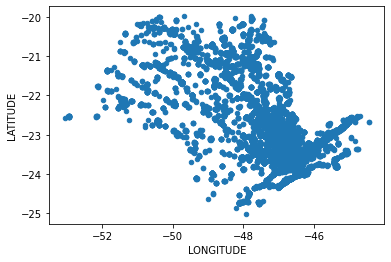

In [17]:
final_data.plot.scatter(x='LONGITUDE', y='LATITUDE')

Define column types

In [27]:
col_types = {
    'file_download_year': float,
    'file_download_month': float,
    'NUMERO': float,
    'LATITUDE': float,
    'LONGITUDE': float,
    'ANO_FABRICACAO': float,
    'ANO_MODELO': float,
    
}

for col in final_data.columns:
    if col in col_types.keys():
        col_type = col_types[col]
    else:
        col_type = str
    print(col)
    final_data[col] = final_data[col].astype(col_type)
    

incident_type
file_download_year
file_download_month
NUMERO_BOLETIM
BO_INICIADO
BO_EMITIDO
DATAOCORRENCIA
HORAOCORRENCIA
LOGRADOURO
NUMERO
BAIRRO
CIDADE
LATITUDE
LONGITUDE
DESCRICAOLOCAL
STATUS
BO_AUTORIA
RUBRICA
DESDOBRAMENTO
TIPOPESSOA
VITIMAFATAL
NATURALIDADE
NACIONALIDADE
SEXO
DATANASCIMENTO
IDADE
NATUREZAVINCULADA
TIPOVINCULO
PLACA_VEICULO
UF_VEICULO
CIDADE_VEICULO
DESCR_COR_VEICULO
DESCR_MARCA_VEICULO
ANO_FABRICACAO
ANO_MODELO
DESCR_TIPO_VEICULO


Convert columns to lower case

In [32]:
final_data = final_data.rename(columns={col:col.lower() for col in final_data.columns}).reset_index().drop(columns='index')
final_data.head()


,incident_type,file_download_year,file_download_month,numero_boletim,bo_iniciado,bo_emitido,dataocorrencia,horaocorrencia,logradouro,numero,...,naturezavinculada,tipovinculo,placa_veiculo,uf_veiculo,cidade_veiculo,descr_cor_veiculo,descr_marca_veiculo,ano_fabricacao,ano_modelo,descr_tipo_veiculo
0,roubo,2020.0,12.0,1846185/2020,01/12/2020 00:11:08,01/12/2020 00:11:08,30/11/2020,21:30,RUA GUIANA,1190.0,...,nan,nan,DQY8787,SP,MOGI DAS CRUZES,Cinza,I/HONDA FIT EX,2005.0,NaN,AUTOMOVEL
1,roubo,2020.0,12.0,1846149/2020,01/12/2020 00:11:28,01/12/2020 00:11:31,29/11/2020,23:40,RUA ENGENHEIRO MANOEL FERRAMENTA JÃNIOR,363.0,...,nan,nan,nan,nan,nan,Prata,nan,NaN,NaN,MOTOCICLO
2,roubo,2020.0,12.0,1846149/2020,01/12/2020 00:11:28,01/12/2020 00:11:31,29/11/2020,23:40,RUA ENGENHEIRO MANOEL FERRAMENTA JÃNIOR,363.0,...,nan,nan,EHA2B71,SP,SÃO VICENTE,Preta,YAMAHA/XT 660R,2009.0,NaN,MOTOCICLO
3,roubo,2020.0,12.0,5302/2020,30/11/2020 21:35:51,01/12/2020 00:17:52,30/11/2020,19:00,RUA FRANCISCO CARDOSO JUNIOR,50.0,...,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,nan
4,roubo,2020.0,12.0,5302/2020,30/11/2020 21:35:51,01/12/2020 00:17:52,30/11/2020,19:00,RUA FRANCISCO CARDOSO JUNIOR,50.0,...,nan,nan,DXX6015,SP,S.PAULO,Preta,RENAULT/CLIO AUT10 16H3P,2007.0,2007.0,AUTOMOVEL


---
## 3. Create a table in Postgres to store this data

Connect to the db

In [1]:
# Imports
import pandas as pd
import numpy as np
import psycopg2, os
from tqdm import tqdm

#!pip install pyshp
import shapefile

# Establish connection and create its cursor
try: 
    conn = psycopg2.connect(f"host={os.environ['AURORA_POSTGRES_HOST']} dbname={os.environ['AURORA_POSTGRES_DATABASE']} user={os.environ['AURORA_POSTGRES_USERNAME']} password={os.environ['AURORA_POSTGRES_PWD']}")
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)
    

### 3.1. Create the table

In [57]:
# Redefine columns types
col_types = {
    'file_download_year': 'numeric',
    'file_download_month': 'numeric',
    'numero': 'numeric',
    'latitude': 'numeric',
    'longitude': 'numeric',
    'ano_fabricacao': 'numeric',
    'ano_modelo': 'numeric',
    }

# Create the statement to be executed for table creation
col_types = {k.lower(): v for k,v in col_types.items()}
create_statement = f"CREATE TABLE staging_tables.stg_roubo_e_furto ({', '.join([k+' '+col_types[k] if k in col_types.keys() else k+' varchar' for k in final_data.columns])})"
cur.execute(create_statement)
conn.commit()



### 3.2. Populate the table

In [58]:
for i, record in tqdm(final_data.iterrows()):
    insert_statement = f"INSERT INTO staging_tables.stg_roubo_e_furto ({', '.join(record.index)}) VALUES ({', '.join(['%s']*len(record))})"
    cur.execute(insert_statement,
                tuple([v for k,v in record.items()])
               )
    
conn.commit()


140144it [4:13:59,  9.20it/s]


### 3.3 Create a geography columns

In [12]:
# Create the column
cur.execute("ALTER TABLE staging_tables.stg_roubo_e_furto ADD COLUMN incident_location geometry(Point, 4326);")
conn.commit()

# Populate the column
cur.execute("UPDATE staging_tables.stg_roubo_e_furto SET incident_location = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326)")
conn.commit()
